# Цель

Практический проект по построению системы поиска аномалий.
Цель: В этом домашнем задании вы попробуете найти патологии в электрокардиографии плода. В датасете, собранном университетом Порто (Португалия), есть не так много наблюдений с патологиями, поэтому имеет смысл попробовать поиск аномалий, а не только классификацию.
1. Возьмите данные по электрокардиографии плода (файл cardio.mat в материалах) и загрузите их в питон при помощи следующих манипуляций:

import pandas as pd
import scipy.io
data= scipy.io.loadmat('cardio.mat')

X = pd.DataFrame(data['X'])
y = pd.DataFrame(data['y'])

2. Используйте все измерения X для построения алгоритмов поиска аномалий, которые умеют работать с "загрязненными" данными (DBSCAN, Isolation Forest). Для настройки гиперпараметров моделей, используйте процент аномалий равный 9.6%

3. При помощи разметки y, постройте confusion_matrix для предсказаний вашей модели по всем данным

4. Теперь возьмите подвыборку измерений X, в которой y==0 ("чистые данные") и постройте алгоритмы, которые умеют работать только с чистыми данными (Distance-based методы, One Class SVM)

5. Аналогично постройте confusion_matrix для предсказаний вашей модели на всех данных

6. Бонус - попробуйте любые supervised методы для предсказания патологии сердца (для этого сделайте стратифицированный train_test_split, отложив 20% наблюдений для тестирования). Постройте confusion_matrix для тренировочной и тестовой части выборки.

Какие методы сработали лучше?
Критерии оценки: - Построены алгоритмы для "загрязненных данных" + 5 баллов
- Построены алгоритмы для "чистых данных" + 5 баллов
- Бонус + 4 балла 

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM

from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist

# from MulticoreTSNE import MulticoreTSNE as TSNE
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

from sklearn.manifold import TSNE

%matplotlib inline

Напишем функцию для построения `confusion matrix`.

In [2]:
from sklearn import metrics

def plot_confusion_matrix(y_pred, y_truth, labels):
    '''
    'Pretty' implementation of a confusion matrix with some evaluation statistics.
    
    Input:
    y_pred - object with class predictions from the model
    y_truth - object with actual classes
    labels - list containing label names
    '''
    
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Confusion Matrix', size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    print('###################')
    print('Evaluation metrics ')
    print('###################')
    print('Accuracy: {:.4f}'.format(metrics.accuracy_score(y_truth, y_pred)))
    print('Precision: {:.4f}'.format(metrics.precision_score(y_truth, y_pred)))
    print('Recall: {:.4f}'.format(metrics.recall_score(y_truth, y_pred)))
    print('F1: {:.4f}'.format(metrics.f1_score(y_truth, y_pred)))

# 1. Загрузка данных датасета

In [4]:
import scipy.io 
data= scipy.io.loadmat('data/cardio.mat')

## 1.1 EDA

Проведем небольшой разводочный анализ

In [65]:
X = pd.DataFrame(data['X']) 
y = pd.DataFrame(data['y'])

In [66]:
X.head(5)

0         1         2         3         4         5         6   \
0  0.004912  0.693191 -0.203640  0.595322  0.353190 -0.061401 -0.278295   
1  0.110729 -0.079903 -0.203640  1.268942  0.396246 -0.061401 -0.278295   
2  0.216546 -0.272445 -0.203640  1.050988  0.148753 -0.061401 -0.278295   
3  0.004912  0.727346 -0.203640  1.212171 -0.683598 -0.061401 -0.278295   
4 -0.100905  0.363595  1.321366  1.027120  0.141359 -0.061401 -0.278295   

         7         8         9   ...        11        12        13        14  \
0 -1.650444  0.759072 -0.420487  ...  1.485973 -0.798376  1.854728  0.622631   
1 -1.710270  0.759072 -0.420487  ...  1.485973 -0.798376  1.854728  0.278625   
2 -1.710270  1.106509 -0.420487  ...  1.141780 -1.332931  0.314688  2.342663   
3 -1.710270  1.106509 -0.420487  ...  1.141780 -1.332931  0.314688  1.654650   
4 -0.992364 -0.051613 -0.420487  ... -0.208514 -0.085638 -0.565334  0.278625   

         15        16        17        18        19        20  
0  0.963083  0.301464  0.193113  0.231498 -0.289786 -0.493294  
1  0.963083  0.301464  0.129265  0.093563 -0.256385 -0.493294  
2 -0.488279  0.061002  0.065417  0.024596 -0.256385  1.140018  
3 -0.488279  0.061002  0.193113  0.093563 -0.323186  1.140018  
4 -0.488279 -0.059229  0.065417  0.024596 -0.456787  1.140018  

[5 rows x 21 columns]

Построим матрицу корреляции по Пирсону.

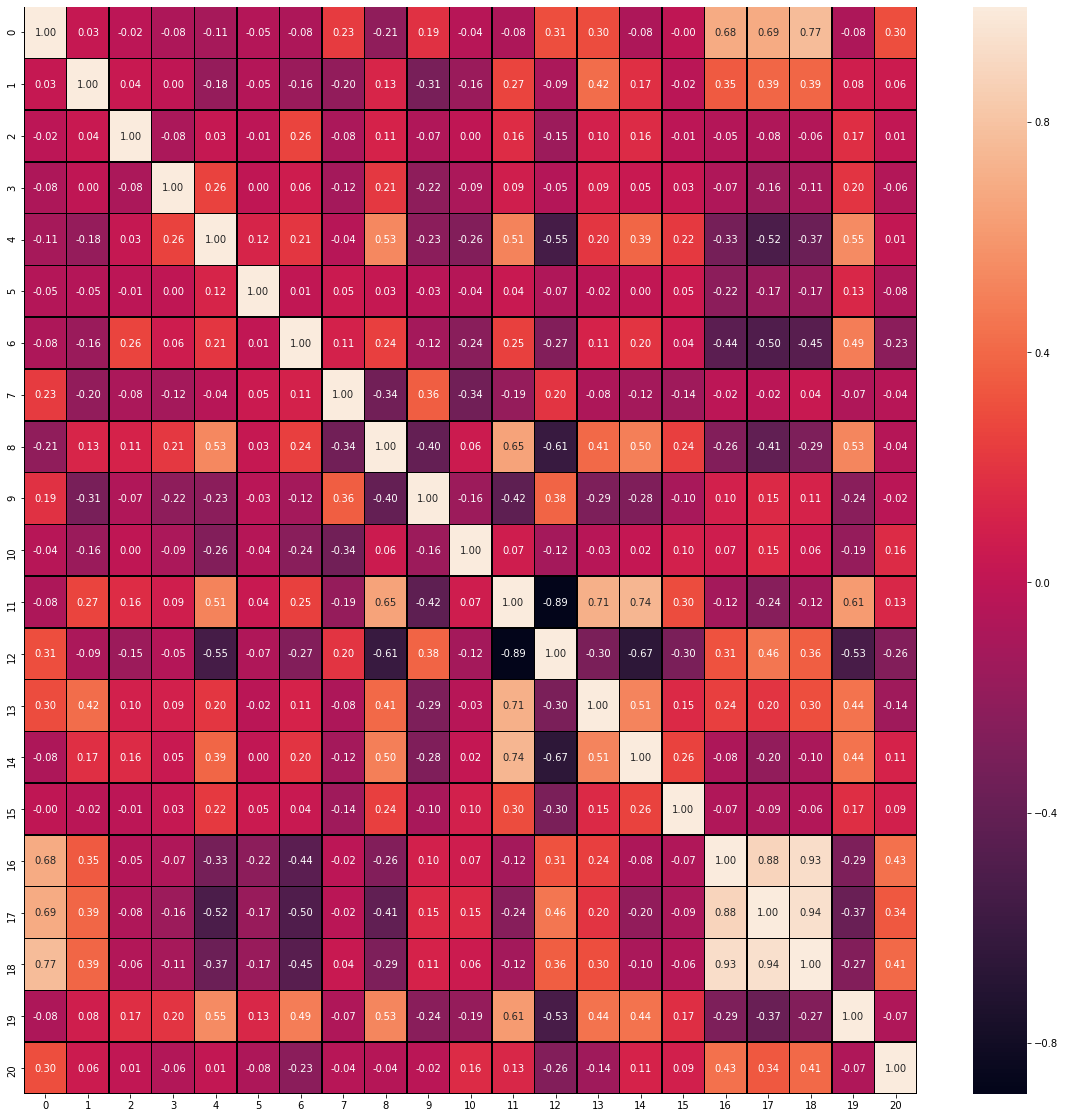

In [8]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt='.2f',ax=ax,linecolor='black');

Из матрицы видно, что признаки `16,17,18` имею высокую прямую корреляцию, а признаки `11,12` - выскоую обратную.

Удалим признаки: `12,17,18`.

In [291]:
X.drop([12,17,18],axis=1,inplace=True)

Построим матрицу заново, без удаленных признаков.

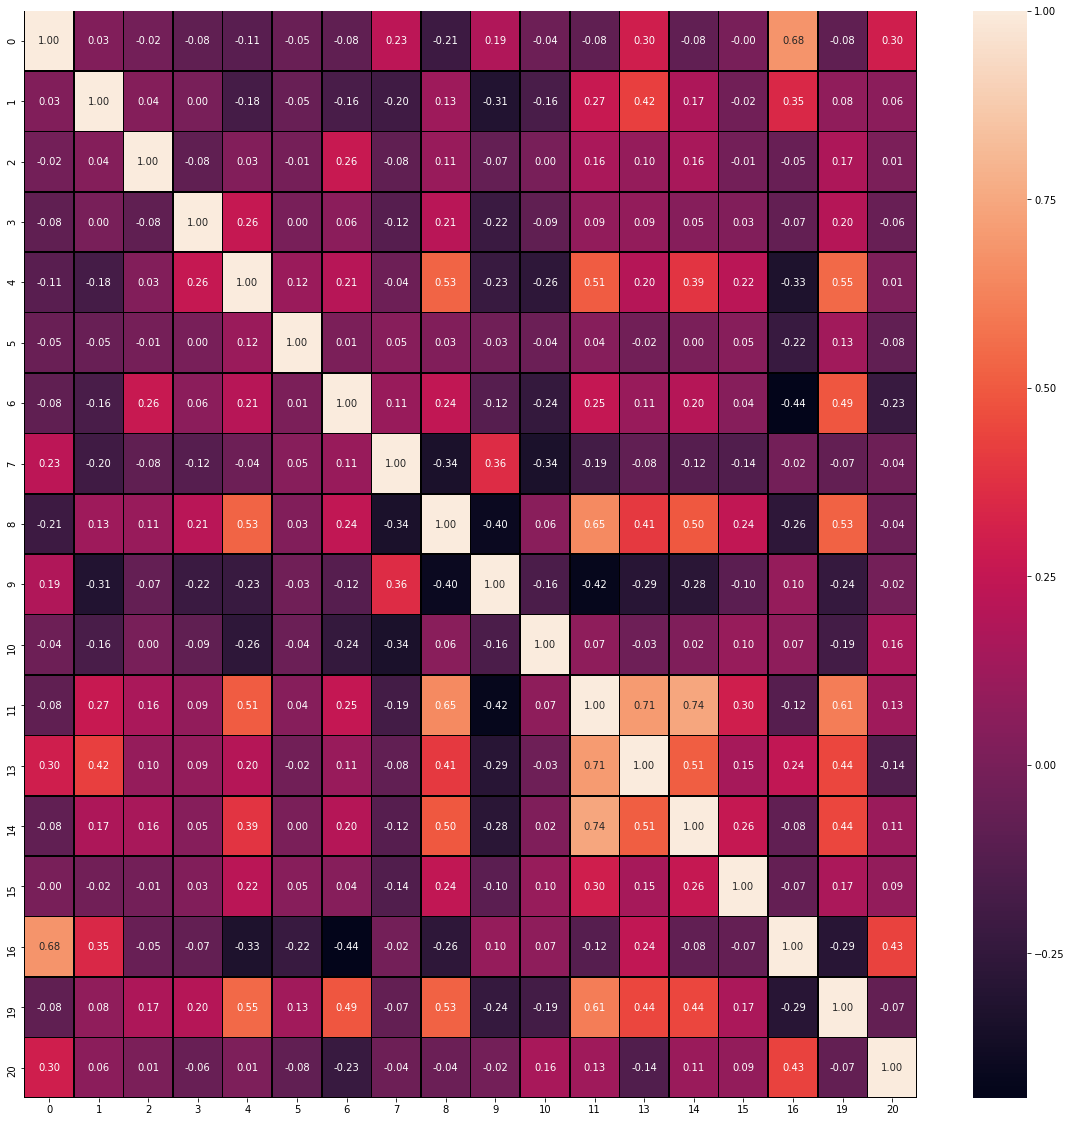

In [292]:
fig, ax = plt.subplots(figsize=(20,20)) 

sns.heatmap(X.corr(), annot=True, linewidths=.5, linecolor='black', fmt='.2f',ax=ax);

Построим графики парных отношений.

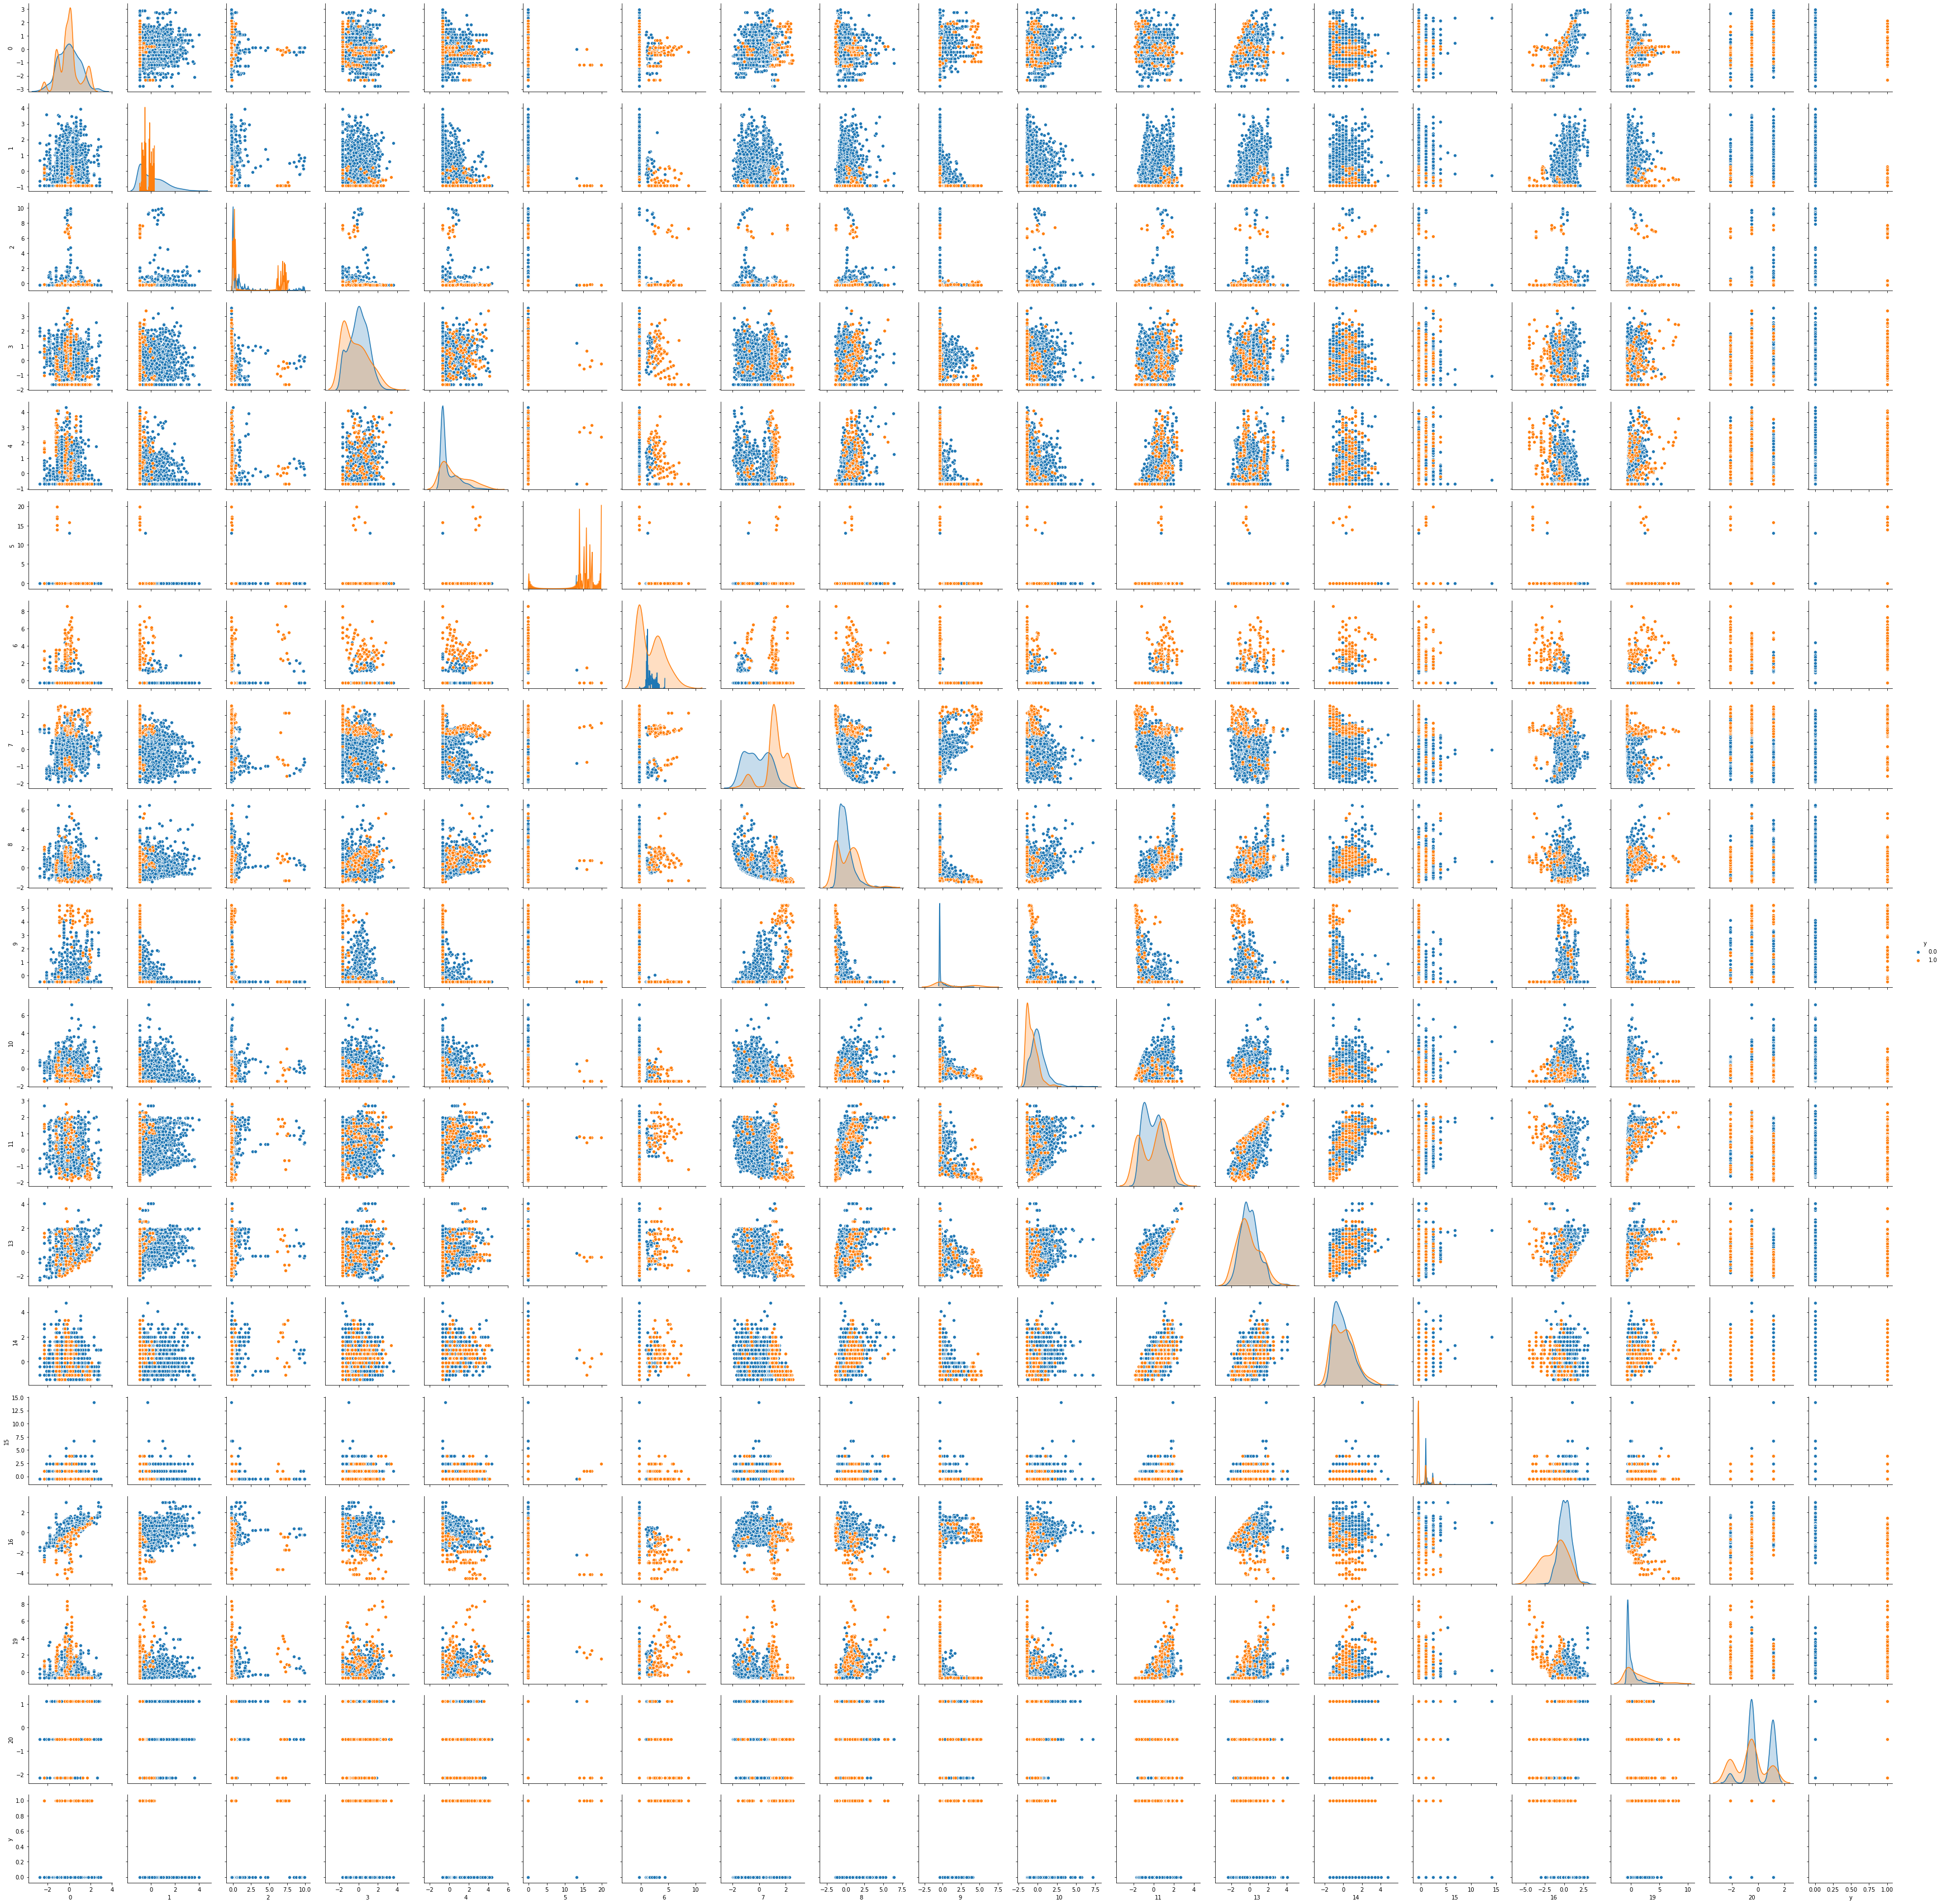

In [293]:
df_full = X.copy(deep=True)
df_full['y'] = y
sns.pairplot(df_full,hue='y');

Из диагональных графиков видно, что в данных нет линейной разделимости.

С помощью t-SNE попробуем посмотреть наличие структуры в данных.

In [294]:
%%time
tsne_result = TSNE(n_components=3, perplexity=30, learning_rate=10).fit_transform(X)

CPU times: user 47.4 s, sys: 827 ms, total: 48.2 s
Wall time: 49.4 s


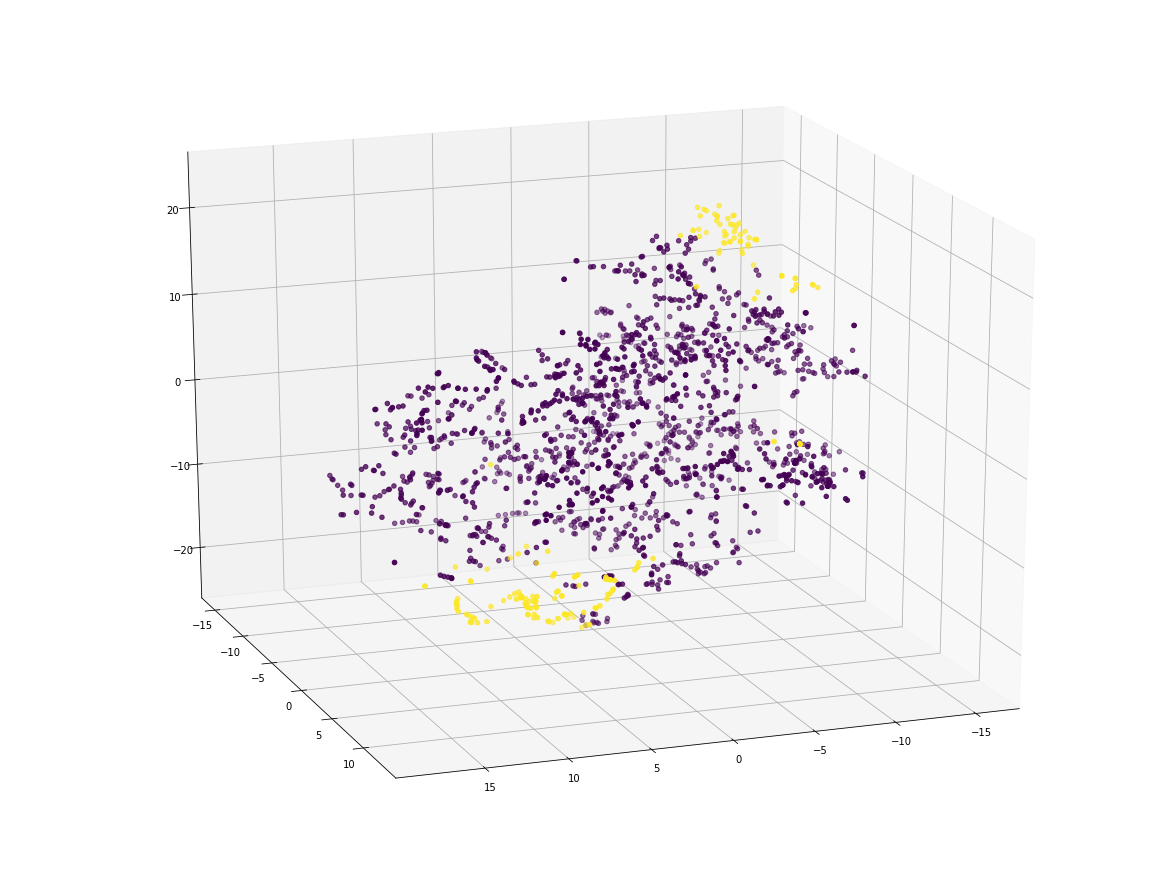

In [295]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,12))
ax = Axes3D(fig)
ax.scatter(tsne_result[:,0], tsne_result[:, 1], tsne_result[:,2],c=y[0])
ax.view_init(20, 70)
plt.show();

В данных действительно есть опредленная структура, это заметно по концентрации целевой переменной на краю облака.

# 2. Unsupervised. Поиск аномалий с "загрязненными" данными

Для поиска аномалии данные возьмем - как есть и будем применять методы DBSCAN, Isolation Forest. Для настройки гиперпараметров моделей, будем использовать процент аномалий равный 9.6%

Произведем стандартизацию данных.

In [296]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

## 2.1 DBScan

Подберем параметр eps, при условии не превышения выбросов 9,6%.

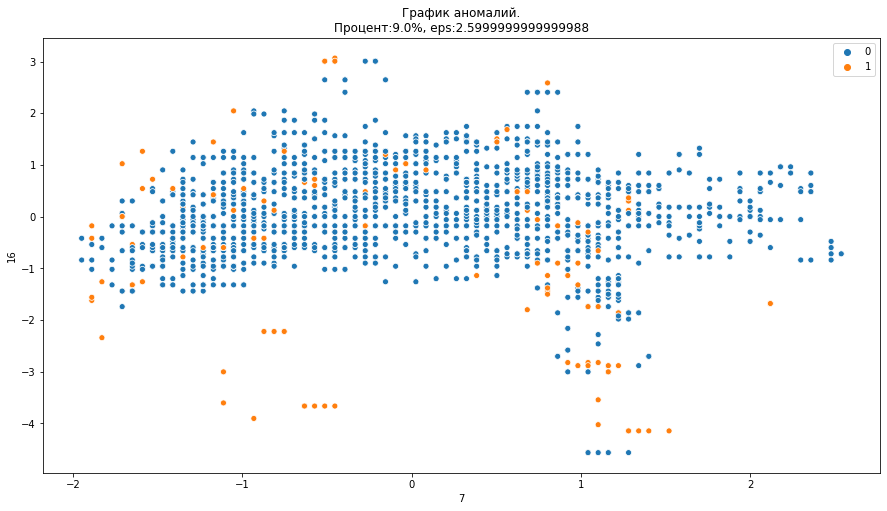

In [297]:
outlier_percentage = 100
eps = 1

while outlier_percentage>9.6:
    model = DBSCAN(eps=eps).fit(X_scaled)
    labels = model.labels_
    labels = np.array([1 if label == -1 else 0 for label in labels])
    outlier_percentage = round(sum(labels)/len(labels)*100)#np.mean(sum(labels==1))
    eps += 0.05
    
model = DBSCAN(eps)

plt.figure(figsize=(15,8))
plt.title('График аномалий.\nПроцент:{}%, eps:{}'.format(outlier_percentage,eps))
sns.scatterplot(x=X[7],y=X[16],hue=labels);

###################
Evaluation metrics 
###################
Accuracy: 0.8749
Precision: 0.3172
Recall: 0.2614
F1: 0.2866


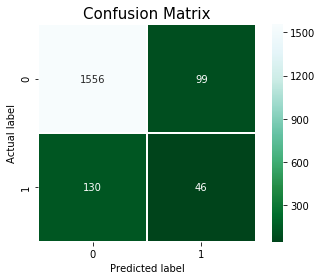

In [298]:
model = DBSCAN(eps)
model.fit(X_scaled)
predicted_labels = np.array([1 if label == -1 else 0 for label in model.labels_])

plot_confusion_matrix(predicted_labels,y,[0,1]);

Результаты получились неудовлетворительные по всем метрикам.

## 2.2 Isolation Forest

Процент выбросов установим через параметр: `contamination`.

In [299]:
from sklearn.ensemble import IsolationForest

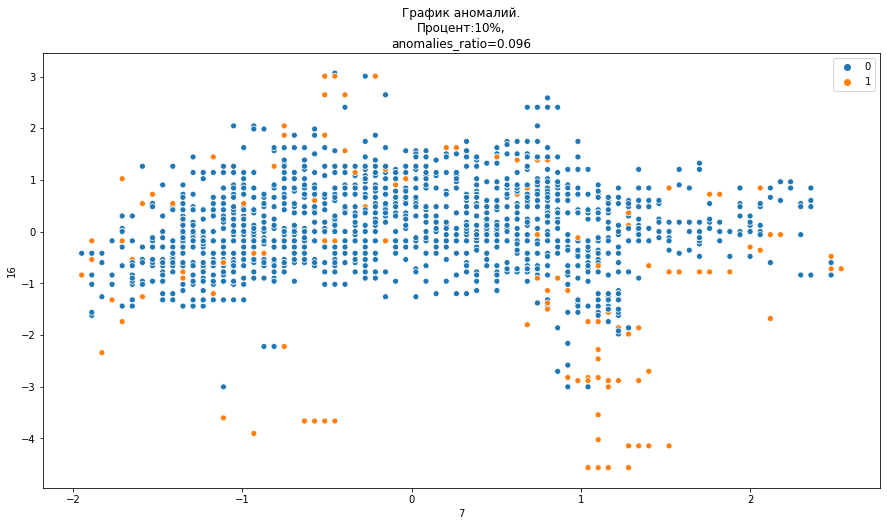

In [300]:
anomalies_ratio = 0.096

if_sk = IsolationForest(n_estimators = 100, 
                        max_samples = 256,
                        contamination = anomalies_ratio, 
                        behaviour= " new", 
                        random_state = np.random.RandomState(42))
if_sk.fit(X)
y_pred = if_sk.predict(X)
y_pred = [1 if x == -1 else 0 for x in y_pred]

outlier_percentage = round(sum(y_pred)/len(y_pred)*100)

plt.figure(figsize=(15,8))
plt.title('График аномалий.\nПроцент:{}%,\nanomalies_ratio={}'.format(outlier_percentage,anomalies_ratio))
sns.scatterplot(x=X[7],y=X[16],hue=y_pred);

###################
Evaluation metrics 
###################
Accuracy: 0.8995
Precision: 0.4773
Recall: 0.4773
F1: 0.4773


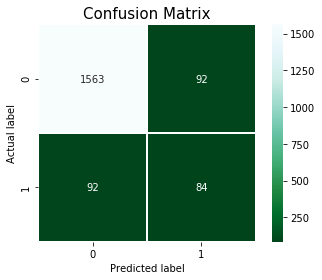

In [301]:
plot_confusion_matrix(y_pred, y, [0, 1]);

Результаты получились существенно лучше, но пока хорошого разделения достичь не удалось.

# 3. Unsupervised. Поиск аномалий с "чистыми" данными

Далее будем проводить обучение моделей с "чистыми" данными.

## 3.1 OneClass SVM

In [302]:
df_full = X.copy(deep=True)
df_full['y'] = y

X_clean = df_full[df_full.y == 0.0].drop('y',axis=1).copy(deep=True)
X_clean_scaled = sc.fit_transform(X_clean)
X_scaled = sc.fit_transform(df_full.drop('y', axis=1))

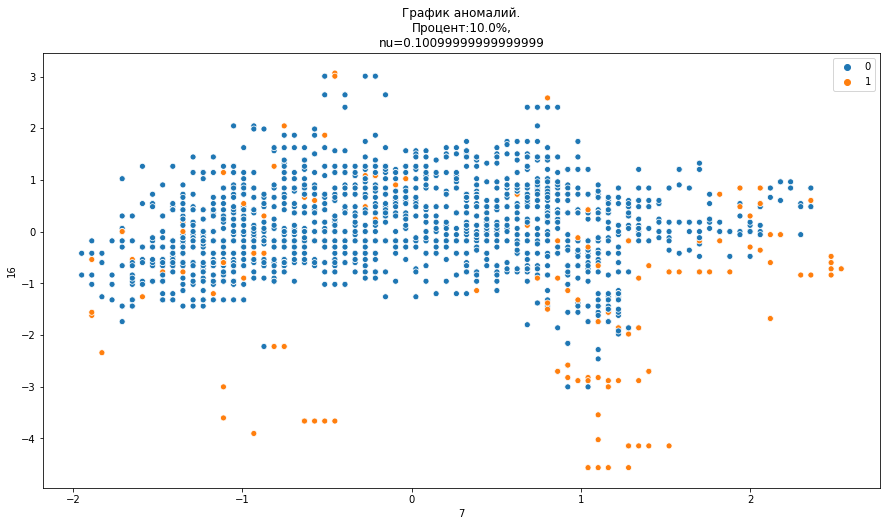

In [303]:
outlier_percentage = 0
nu=0.001

while outlier_percentage<9.6:
    model = OneClassSVM(nu=nu) #0.1
    model.fit(X_clean_scaled)
    preds = model.predict(X_scaled)
    preds = np.array([1 if label == -1 else 0 for label in preds])

    outlier_percentage = round(sum(preds)/len(preds)*100)
    nu += 0.01
    
preds = model.predict(X_scaled)
preds = np.array([1 if label == -1 else 0 for label in preds])

plt.figure(figsize=(15,8))
plt.title('График аномалий.\nПроцент:{}%,\nnu={}'.format(outlier_percentage,nu))
sns.scatterplot(x=X[7],y=X[16],hue=preds);

###################
Evaluation metrics 
###################
Accuracy: 0.9214
Precision: 0.5920
Recall: 0.5852
F1: 0.5886


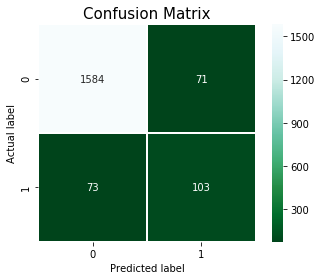

In [304]:
plot_confusion_matrix(preds, y, [0, 1]);

Результаты с чистым данными получились лучше. Мы уже предсказывам верно больше выбросов, чем ошибаемся, также стали меньше ошибаться в действительных данных.

## 3.2 Isolation Forest

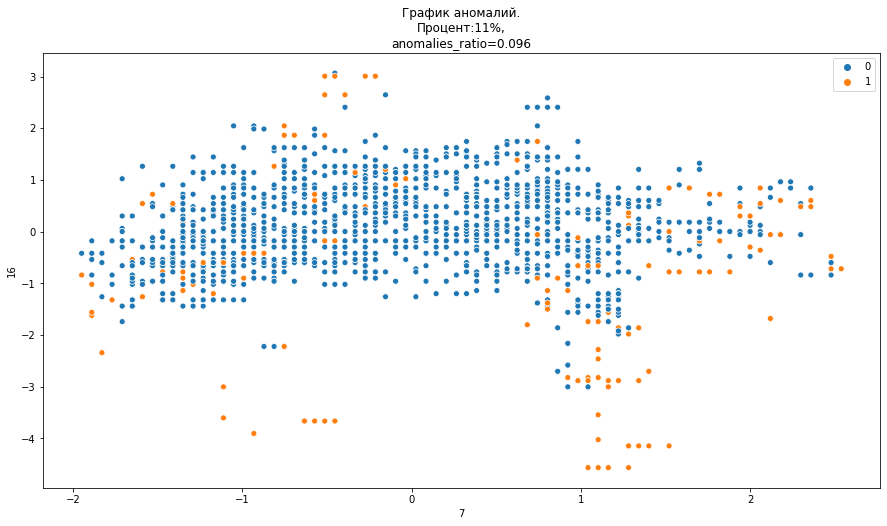

In [305]:
anomalies_ratio = 0.096

if_sk = IsolationForest(n_estimators = 100, 
                        max_samples = 256,
                        contamination = anomalies_ratio, 
                        behaviour= " new", 
                        random_state = np.random.RandomState(42))
if_sk.fit(X_clean_scaled)
y_pred = if_sk.predict(X_scaled)
y_pred = [1 if x == -1 else 0 for x in y_pred]

outlier_percentage = round(sum(y_pred)/len(y_pred)*100)

plt.figure(figsize=(15,8))
plt.title('График аномалий.\nПроцент:{}%,\nanomalies_ratio={}'.format(outlier_percentage,anomalies_ratio))
sns.scatterplot(x=X[7],y=X[16],hue=y_pred);

###################
Evaluation metrics 
###################
Accuracy: 0.9121
Precision: 0.5369
Recall: 0.6193
F1: 0.5752


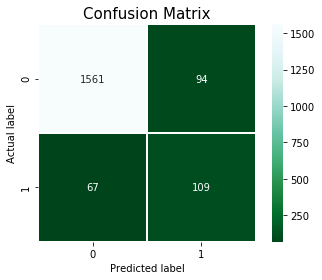

In [306]:
plot_confusion_matrix(y_pred, y, [0, 1]);

В данном случае еще улучшили результат, несмотря на увеличение ошибки в действительных данных.

# 4. Supervised

Теперь попробуем сравнить с методоми обучение с учителем. В качестве такого метода будем использовать логистическую регрессию.

In [308]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

Разделем выборку на тренировочную и тестовую, проведем нормализацию и пострим модель с подбором гиперпараметров.

In [309]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop('y', axis=1), 
    df_full['y'], 
    test_size=0.30, 
    random_state=42, 
    stratify=df_full['y']
)

X_train_scaled = sc.fit_transform(X_train)

log_reg_cv = LogisticRegressionCV(Cs=100, random_state=42)
log_reg_cv.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=42, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

###################
Evaluation metrics 
###################
Accuracy: 0.9664
Precision: 0.9878
Recall: 0.6585
F1: 0.7902


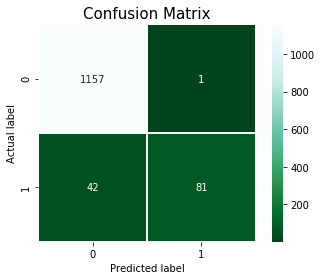

In [311]:
y_pred_train = log_reg_cv.predict_proba(X_train_scaled)[:, 1]>0.8

plot_confusion_matrix(y_pred_train, y_train, [0, 1]);

На тренировочной выборке получились хорошие результаты.

Посмотрим, на результаты по тестовой выборке.

###################
Evaluation metrics 
###################
Accuracy: 0.9836
Precision: 1.0000
Recall: 0.8302
F1: 0.9072


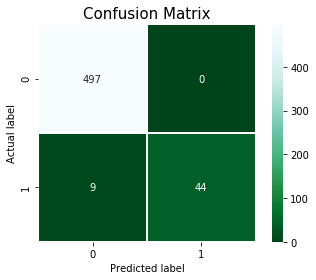

In [290]:
X_test_scaled = sc.transform(X_test)
y_pred_test = log_reg_cv.predict_proba(X_test_scaled)[:, 1]>0.8

plot_confusion_matrix(y_pred_test, y_test, [0, 1]);

Логистическая регрессия показала самый лучшим результат.

Сделаем предсказание по все выборке для сранвения результатов.

###################
Evaluation metrics 
###################
Accuracy: 0.9683
Precision: 0.9836
Recall: 0.6818
F1: 0.8054


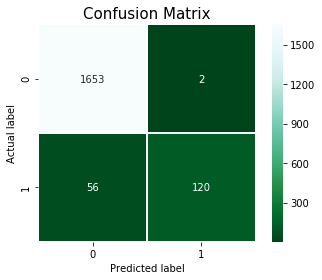

In [313]:
X_test_scaled = sc.transform(X)
y_pred_test = log_reg_cv.predict_proba(X_test_scaled)[:, 1]>0.8

plot_confusion_matrix(y_pred_test, y, [0, 1]);

# Выводы

1. Были построены модели для поиска аномалий в "чистых" и "грязных" данных
1. Лучшее качество фиксации аномалий предсказали модели с чистыми данными
1. Сравнение `Isolation forest` и `Logistic regression` как `Unsupervised и Supervised` методами показло, что лучшем качество обладают методы `Supervised`.